# CNN

In [1]:
# importing libraries

%load_ext tensorboard
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle
#from transformers import 
import numpy as np
from numpy import zeros, newaxis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
import random as rn
import tensorflow 

from wordcloud import WordCloud, STOPWORDS 

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

import tensorflow as tf
from tensorflow.keras.layers import Conv1D,AveragePooling1D,MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Input,concatenate,Activation,Dropout,BatchNormalization,LSTM
from tensorflow.keras import regularizers,Model
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import TensorBoard, Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler


from matplotlib_venn import venn2, venn2_unweighted
from matplotlib_venn import venn3, venn3_unweighted
%matplotlib inline

In C:\Users\JAYANY\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\JAYANY\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\JAYANY\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\JAYANY\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\JAYANY\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# https://stackoverflow.com/a/47091490/4084039
import re

def preprocess_text(phrase):
    # specific
    phrase = str(phrase)
    phrase = phrase.lower()
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrade = re.sub(r"wont", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"cant", "can not", phrase)
    phrase = re.sub(r"cannot", "can not", phrase)
    phrase = re.sub(r"doesn't", "does not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\"', ' ')
    phrase = phrase.replace('\\n', ' ')
    phrase = phrase.replace('\\', ' ')
    
    #phrase = re.sub(r'http\S+', '', phrase)  # for removal all http link
    phrase = re.sub(r'[^A-Za-z0-9]', ' ',phrase) # remove everything except alphaets and numbers
    
    sent = ''
    for val in phrase.split():          # removing multiple spaces between words
        sent = sent + ' ' + val
    sent = sent.strip()
    
    return sent
    


In [3]:
def get_sentiments(df,column_list):
    '''
    sentiments from question_title
    '''
     
    for col in column_list:
        
        sid = SentimentIntensityAnalyzer()
        neg=[]
        neu=[]
        pos=[]
        comp=[]
    
        for txt in df[col]:
            ss = sid.polarity_scores(txt)
            neg.append(ss['neg'])
            neu.append(ss['neu'])
            pos.append(ss['pos'])
            comp.append(ss['compound'])

        df[col+"_neg"] = neg
        df[col+"_neu"] = neu
        df[col+"_pos"] = pos
        df[col+"_comp"] = comp
    
    return df

In [4]:
def cnn_model(train_vect_text, train_vect_cat_num):
    '''
    function to create CNN Model architecture
    '''

    #fixing numpy RS
    np.random.seed(42)

    #fixing tensorflow RS
    tensorflow.random.set_seed(32)
    
    #python RS
    rn.seed(12)

    #input 1
    input1 = Input(shape=(train_vect_text.shape[1],1), name = 'input_1')
    conv = Conv1D(filters = 32, kernel_size = 11,strides = 3, activation='relu',
                  kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
                  kernel_regularizer=tensorflow.keras.regularizers.l2(0.1),
                  input_shape=(None,train_vect_text.shape[1],1))(input1)
    conv = MaxPooling1D()(conv)
    conv = Conv1D(32, 11, activation='relu',kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43))(conv)
    conv = MaxPooling1D()(conv)
    flat_text = Flatten()(conv)
    out_1 =  Dense(30,activation='sigmoid')(flat_text)
    #====================================================================================================================

    #input 2
    input2 = Input(shape=(train_vect_cat_num.shape[1],1), name = 'input_2')
    conv = Conv1D(filters = 64, kernel_size = 3,strides = 2, activation='relu',
                  kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43),
                  kernel_regularizer=tensorflow.keras.regularizers.l2(0.1),
                  input_shape=(None,train_vect_cat_num.shape[1],1))(input2)

    conv = MaxPooling1D()(conv)
    conv = Conv1D(32, 3,  activation='relu',kernel_initializer=tensorflow.keras.initializers.he_normal(seed=43))(conv)
    conv = MaxPooling1D()(conv)
    flat_rem = Flatten()(conv)
    out_2 =  Dense(30,activation='sigmoid')(flat_rem)
    #====================================================================================================================

    final_data = concatenate([out_1,out_2])

    #====================================================================================================================

    output = Dense(30,activation='sigmoid',kernel_initializer=tensorflow.keras.initializers.glorot_uniform(seed=45))(final_data)

    # create model with 2 inputs
    model = Model([input1,input2], output)

    model.compile(loss=tensorflow.keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(0.001),
              metrics=['mae'])
    
    return model

In [5]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model


In [6]:
def countVectorizer(df_train,df_cv,column):
    '''
    function to vectorize categorical data
    '''
    # one-hot encoding 'category' feature
    vect = CountVectorizer(binary=True)
    vect.fit(df_train[column])
    encoded_train = vect.transform(df_train[column]).todense()
    encoded_cv = vect.transform(df_cv[column]).todense()
    
    return encoded_train, encoded_cv, vect

In [7]:
def get_average_w2v(df,column,glove_vector,glove_words):
    '''
    function to vectorize text data into average word2vec
    '''    
    # computing average word2vec for each question title
    avg_w2v_vectors = []; # the avg-w2v for each question title is stored in this list
    for sentence in tqdm(df[column]): # for each question title
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the question title
        for word in sentence.split(): # for each word in a question title
            if word in glove_words:
                vector += glove_vector[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
        
    return avg_w2v_vectors


In [8]:
from scipy.stats import spearmanr
def spearman(y_true,y_pred):
    '''
    function to calculate mean spearman correlation of all 30 class-labels
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    spearman_y = []
    for i in range(30):
        score = spearmanr(y_true[:,i], y_pred[:,i] + np.random.normal(0, 1e-7, y_pred.shape[0]) , 
                                                                        nan_policy='omit').correlation
                                                                        

        spearman_y.append(score)
    mean_score = np.nanmean(spearman_y)
    return mean_score

### ERROR ANALYSIS ON CNN

First, training the model

In [9]:
# reading data from csv file    
train = pd.read_csv("google-quest-challenge/train.csv")
    
#=================================PREPROCESSING===================================
    
# preprocessing host name 
train['host'] = train['host'].apply(lambda x: x.split('.')[-2])
train['host'] = train['host'].apply(lambda x: x.lower())
train['host'] = train['host'].apply(lambda x: x.strip())
    
# preprocessing 'category' to lower-case and stripping leading and tailing spaces 
train['category'] = train['category'].apply(lambda x: x.lower())
train['category'] = train['category'].apply(lambda x: x.strip())
    
# preprocessing question title, question body and answers
train['question_title'] = train['question_title'].apply(lambda x: preprocess_text(x))
train['question_body'] = train['question_body'].apply(lambda x: preprocess_text(x))
train['answer'] = train['answer'].apply(lambda x: preprocess_text(x))
    
#=================================FEATURE ENGINEERING=============================
    
# taking length of question title, question body, answer
train['q_title_length'] = train['question_title'].apply(lambda x: len(x.split(' ')))
train['q_body_length'] = train['question_body'].apply(lambda x: len(x.split(' ')))
train['answer_length'] = train['answer'].apply(lambda x: len(x.split(' ')))
    
train = get_sentiments(train,['question_title','question_body','answer'])
    
#=================================Splitting data===================================
    
# input columns to be used for training model
input_columns = ['question_title', 'question_body','answer','category', 'host','q_title_length', 'q_body_length',
                     'answer_length', 'question_title_neg', 'question_title_neu', 'question_title_pos','question_title_comp',
                     'question_body_neg', 'question_body_neu', 'question_body_pos', 'question_body_comp','answer_neg', 
                     'answer_neu', 'answer_pos', 'answer_comp']
    
class_labels = ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 
                    'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 
                    'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                    'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 
                    'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                    'question_type_entity', 'question_type_instructions', 'question_type_procedure', 
                    'question_type_reason_explanation', 'question_type_spelling', 'question_well_written',
                    'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 
                    'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                    'answer_type_reason_explanation', 'answer_well_written']
    
X = train[input_columns]
Y = train[class_labels]
print(X.shape,Y.shape)    

x_train,x_cv,y_train,y_cv = train_test_split(X,Y, test_size=0.1)
    
print("Shape after split:")
print("Train Shape = ",x_train.shape,y_train.shape)
print("CV Shape = ",x_cv.shape,y_cv.shape)

(6079, 20) (6079, 30)
Shape after split:
Train Shape =  (5471, 20) (5471, 30)
CV Shape =  (608, 20) (608, 30)


In [10]:
#=================================Encoding===========================================
   
# Encoding categorical data
category_encoded_train, category_encoded_cv, category_vectorizer = countVectorizer(x_train,x_cv,'category')
host_encoded_train, host_encoded_cv, host_vectorizer = countVectorizer(x_train,x_cv,'host')

# Encoding text data
glove_model = loadGloveModel('D:\APPLIEDAI Notebooks TEMP BACKUP\glove.42B.300d.txt')
words = []
for i in train['question_title']:
    words.extend(i.split(' '))
for i in train['question_body']:
    words.extend(i.split(' '))
for i in train['answer']:
    words.extend(i.split(' '))

print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))
    
inter_words = set(glove_model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
           len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")
glove_vector = {}
words_glove = set(glove_model.keys())
    
for i in words:
    if i in words_glove:
        glove_vector[i] = glove_model[i]
print("word 2 vec length", len(glove_vector))

# saving variables into a pickle file
with open('glove_vectors', 'wb') as f:
    pickle.dump(glove_vector, f)

# encoding question_title
avg_w2v_vectors_title_train = get_average_w2v(x_train,'question_title',glove_vector,words_glove)
avg_w2v_vectors_title_cv = get_average_w2v(x_cv,'question_title',glove_vector,words_glove)
    
# encoding question_body
avg_w2v_vectors_body_train = get_average_w2v(x_train,'question_body',glove_vector,words_glove)
avg_w2v_vectors_body_cv = get_average_w2v(x_cv,'question_body',glove_vector,words_glove)
    
# encoding answer
avg_w2v_vectors_answer_train = get_average_w2v(x_train,'answer',glove_vector,words_glove)
avg_w2v_vectors_answer_cv = get_average_w2v(x_cv,'answer',glove_vector,words_glove)
    
#==========================Concatenating encoded data====================================
    
# concatenating encoded vectors of train data

train_vect_text = np.hstack([avg_w2v_vectors_title_train,avg_w2v_vectors_body_train,
                        avg_w2v_vectors_answer_train])
    
train_vect_cat_num = np.hstack([category_encoded_train,host_encoded_train,
                                    x_train[['q_title_length','q_body_length','answer_length', 'question_title_neg',
                                             'question_title_neu', 'question_title_pos', 'question_title_comp', 
                                             'question_body_neg','question_body_neu', 'question_body_pos', 'question_body_comp', 
                                             'answer_neg','answer_neu', 'answer_pos', 'answer_comp']]])

cv_vect_text = np.hstack([avg_w2v_vectors_title_cv, avg_w2v_vectors_body_cv, avg_w2v_vectors_answer_cv])

cv_vect_cat_num = np.hstack([category_encoded_cv,host_encoded_cv,
                                 x_cv[['q_title_length','q_body_length','answer_length', 'question_title_neg',
                                       'question_title_neu', 'question_title_pos', 'question_title_comp', 
                                       'question_body_neg','question_body_neu', 'question_body_pos', 'question_body_comp', 
                                       'answer_neg','answer_neu', 'answer_pos', 'answer_comp']]])

print("Shape of train encoded data: ",train_vect_text.shape,train_vect_cat_num.shape)
print("Shape of cross-validation encoded data: ",cv_vect_text.shape,cv_vect_cat_num.shape)
    
# reshaping data for convolution layer
train_vect_text = train_vect_text[:,:,newaxis]
train_vect_cat_num = train_vect_cat_num[:,:,newaxis]
cv_vect_text = cv_vect_text[:,:,newaxis]
cv_vect_cat_num = cv_vect_cat_num[:,:,newaxis]


100%|██████████████████████████████████████████████████████████████████████████████| 608/608 [00:00<00:00, 4507.10it/s]


Shape of train encoded data:  (5471, 900) (5471, 26)
Shape of cross-validation encoded data:  (608, 900) (608, 26)


In [12]:
# creating a CNN model 
model = cnn_model(train_vect_text,train_vect_cat_num)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 900, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 26, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 297, 32)      384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 12, 64)       256         input_2[0][0]                    
_______________________________________________________________________________________

In [12]:
# tensorboard for logs of loss and error for each iteration
tensorboard = tensorflow.keras.callbacks.TensorBoard(log_dir='logs_p3',histogram_freq=0, write_graph=True,write_grads=True,write_images=True)

# checkpoint model for best weights
filepath="weights_cnnp3.best_copy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

# fitting model on train data
history_model = model.fit([train_vect_text,train_vect_cat_num], y_train, 
                                 epochs=70,
                                 verbose=2,batch_size=64,
                                 callbacks = [checkpoint,tensorboard],
                                 validation_split = 0.1)



Epoch 1/70
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
77/77 - 3s - loss: 17.3847 - mae: 0.2602 - val_loss: 15.6595 - val_mae: 0.1967
Epoch 2/70
77/77 - 1s - loss: 14.2786 - mae: 0.1876 - val_loss: 12.9615 - val_mae: 0.1781
Epoch 3/70
77/77 - 1s - loss: 11.8583 - mae: 0.1780 - val_loss: 10.7976 - val_mae: 0.1737
Epoch 4/70
77/77 - 1s - loss: 9.9015 - mae: 0.1744 - val_loss: 9.0371 - val_mae: 0.1709
Epoch 5/70
77/77 - 1s - loss: 8.3021 - mae: 0.1703 - val_loss: 7.5911 - val_mae: 0.1656
Epoch 6/70
77/77 - 1s - loss: 6.9872 - mae: 0.1656 - val_loss: 6.4012 - val_mae: 0.1608
Epoch 7/70
77/77 - 1s - loss: 5.9025 - mae: 0.1616 - val_loss: 5.4190 - val_mae: 0.1601
Epoch 8/70
77/77 - 1s - loss: 5.0049 - mae: 0.1595 - val_loss: 4.6030 - val_mae: 0.1567
Epoch 9/70
77/77 - 1s - loss: 4.2590 - mae: 0.1578 - val_loss: 3.9235 - val_mae: 0.1537
Epoch 10/70
77/77 - 1s - loss: 3.6375 - mae: 0.1559 - val_loss: 3.3581 - val_mae: 0.1535
Epoch 11/70
77/77 - 1s - loss: 3.1189 - m

In [13]:
# loading best weights for prediction
model.load_weights("weights_cnnp3.best_copy.hdf5")
    
# predicting on train data and calculating spearman correlation 
y_tr_pred = model.predict([train_vect_text,train_vect_cat_num])
print("Spearman's correlation on train data = ",spearman(y_train,y_tr_pred))
    
# predicting on cross-validation data and calculating spearman correlation 
y_cv_pred = model.predict([cv_vect_text,cv_vect_cat_num])
print("Spearman's correlation on cross-validation data = ",spearman(y_cv,y_cv_pred))
    


Spearman's correlation on train data =  0.36269781053146577
Spearman's correlation on cross-validation data =  0.33324250300185604


In [17]:
#%load_ext tensorboard
#%matplotlib inline
%tensorboard --port 6010 --logdir 'logs_p3'

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 20456.

##### Plots of above model: 1. Epochs vs Loss `(epoch_loss)`  ,  2. Epochs vs Mean absolute error `(epoch_mae)`
<img src = 'tensorboard plots/cnn_logs.jpg'>

##### Above Loss and MAE plots shows that the model converges properly with respect to both Cross-entropy loss and Mean absolute error. 
##### There is a very low difference in error and loss of training and validation datasets, which shows that the model is neither overfit nor underfit.

In [42]:
class_labels

['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

In [18]:
# converting y_tr_pred(predicted class-labels values) to a dataframe for ease of analysis

train_pred = pd.DataFrame()
for i,col in enumerate(class_labels):
    train_pred[col] = y_tr_pred[:,i]
train_pred.head()

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.842190,0.444935,0.006993,0.647697,0.772907,0.913881,0.544932,0.394571,0.178193,0.004918,...,0.699653,0.960879,0.725430,0.976861,0.988452,0.912127,0.787813,0.247064,0.775040,0.914424
1,0.871948,0.346529,0.060625,0.601157,0.868070,0.813901,0.631978,0.591814,0.513780,0.003588,...,0.684796,0.945492,0.739306,0.967641,0.979744,0.880568,0.141712,0.112778,0.863922,0.908471
2,0.895817,0.623961,0.011538,0.689049,0.818942,0.849272,0.577935,0.439808,0.168034,0.005365,...,0.807845,0.911325,0.586370,0.956610,0.956302,0.813028,0.749641,0.160370,0.188701,0.885975
3,0.868060,0.568565,0.006964,0.697363,0.750184,0.858343,0.541607,0.412715,0.164778,0.005292,...,0.751896,0.953586,0.655115,0.969749,0.981534,0.895700,0.929312,0.187091,0.145424,0.898760
4,0.884737,0.574903,0.003033,0.722114,0.777130,0.913607,0.561310,0.462750,0.087784,0.004877,...,0.766311,0.932902,0.615147,0.958446,0.973339,0.857192,0.950292,0.149292,0.076999,0.876891


In [19]:
# converting y_cv_pred(predicted class-labels values) to a dataframe for ease of analysis

cv_pred = pd.DataFrame()
for i,col in enumerate(class_labels):
    cv_pred[col] = y_cv_pred[:,i]
cv_pred.head()

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.903385,0.608622,0.015150,0.819148,0.804999,0.892457,0.589374,0.487699,0.174236,0.006284,...,0.786179,0.901678,0.629061,0.951708,0.957911,0.813551,0.410455,0.087877,0.457160,0.888959
1,0.857975,0.384164,0.047518,0.722051,0.610219,0.655795,0.559911,0.472486,0.210205,0.016073,...,0.650639,0.893549,0.576895,0.933182,0.949763,0.783665,0.748021,0.128343,0.101840,0.869682
2,0.858281,0.497978,0.008247,0.661566,0.713622,0.847141,0.561571,0.435707,0.168891,0.006180,...,0.747691,0.941750,0.620215,0.967866,0.978211,0.863850,0.921979,0.218753,0.257482,0.901014
3,0.947306,0.621640,0.329177,0.724694,0.614548,0.411156,0.691587,0.688792,0.317499,0.004988,...,0.857666,0.905705,0.656778,0.963520,0.964076,0.837853,0.064081,0.057673,0.640043,0.923640
4,0.890546,0.554017,0.016480,0.791602,0.734109,0.845582,0.593075,0.465992,0.139084,0.006531,...,0.717988,0.940082,0.662704,0.963615,0.978194,0.876990,0.737243,0.109663,0.250827,0.899501


In [27]:
from sklearn.metrics import mean_absolute_error
mae_dict = dict() #dictionary to save MAE values of columns
for col in y_train.columns:
    mae_dict[col] = mean_absolute_error(y_train[col],train_pred[col])
    print(f"Mean absolute error for {col} on train data : ",mean_absolute_error(y_train[col],train_pred[col]))
    print(f"Mean absolute error for {col} on CV data : ",mean_absolute_error(y_cv[col],cv_pred[col]))
    print("="*70)

Mean absolute error for question_asker_intent_understanding on train data :  0.09577902434704526
Mean absolute error for question_asker_intent_understanding on CV data :  0.09189963069532002
Mean absolute error for question_body_critical on train data :  0.14284398398830248
Mean absolute error for question_body_critical on CV data :  0.15285718527061548
Mean absolute error for question_conversational on train data :  0.07459614933992706
Mean absolute error for question_conversational on CV data :  0.07915198462726772
Mean absolute error for question_expect_short_answer on train data :  0.28035279927237455
Mean absolute error for question_expect_short_answer on CV data :  0.30141657304933717
Mean absolute error for question_fact_seeking on train data :  0.22874038693950347
Mean absolute error for question_fact_seeking on CV data :  0.23534553739029854
Mean absolute error for question_has_commonly_accepted_answer on train data :  0.21827328000924698
Mean absolute error for question_has_c

##### Following columns have a high mean absolute error  (MAE) - 

<p style="background-color:orange;">
    question_expect_short_answer has train MAE = 0.2803 and validation MAE = 0.3014
</p>

<p style="background-color:orange;">
    question_fact_seeking has train MAE = 0.2287 and validation MAE = 0.2353
</p>

<p style="background-color:orange;">
    question_has_commonly_accepted_answer has train MAE = 0.2182 and validation MAE = 0.2268
</p>

<p style="background-color:orange;">
    question_multi_intent has train MAE = 0.2585 and validation MAE = 0.2661
</p>

<p style="background-color:orange;">
    question_opinion_seeking has train MAE = 0.2778 and validation MAE = 0.2776
</p>

<p style="background-color:orange;">
    question_type_choice has train MAE = 0.2791 and validation MAE = 0.2875
</p>

<p style="background-color:orange;">
    question_type_instructions has train MAE = 0.2214 and validation MAE = 0.2318
</p>

<p style="background-color:orange;">
    question_type_reason_explanation has train MAE = 0.2717 and validation MAE = 0.2836
</p>

<p style="background-color:orange;">
    question_type_procedure has train MAE = 0.1991 and validation MAE = 0.2019
</p>

<p style="background-color:orange;">
    answer_type_procedure has train MAE = 0.1736 and validation MAE = 0.1792
</p>

<p style="background-color:orange;">
    answer_type_reason_explanation has train MAE = 0.2629 and validation MAE = 0.2754
</p>


##### Following columns have lowest mean absolute error (MAE) -

<p style="background-color:MediumSeaGreen;">
    question_type_spelling has train MAE = 0.0014 and validation MAE = 0.0023
</p>

<p style="background-color:MediumSeaGreen;">
    question_not_really_a_question has train MAE = 0.0093 and validation MAE = 0.0086
</p>


 From the above error values, it is observed that class-labels that have high error values are mostly needs deeper understanding of text data and it seems that model has an average understanding of actual semantic meaning of the text data.
 
Cass-labels having low error are `question_asker_intent_understanding, question_interestingness_others, question_type_spelling
question_type_compare,question_type_definition,question_type_consequence, question_not_really_a_question`


In [29]:
# function to plot pdf and cdf of class-labels for true and predicted values
def class_dist(df_true,df_pred,column_name,hist=False):
    
    # kde plot of length of question title
    fig = plt.figure(figsize=plt.figaspect(.3))

    ax1 = plt.subplot(121)
    sns.distplot(df_true[column_name],hist=hist ,color='orange',label="True")
    sns.distplot(df_pred[column_name],hist=hist ,color='cyan',label='Predicted')
    
    plt.xlabel(column_name)
    plt.grid()
    plt.title(f"PDF plot of {column_name}")

    ax2 = plt.subplot(122)
    sns.kdeplot(df_true[column_name], shade=True, cumulative=True,color='orange', ax=ax2,label="True")
    sns.kdeplot(df_pred[column_name], shade=True, cumulative=True,color='cyan', ax=ax2,label="Predicted")
    plt.xlabel(column_name)
    plt.title(f'CDF plot of {column_name}')
    plt.grid()
    plt.show()


### Below plots shows the overlap between the distribution of actual and predicted class-labels values.

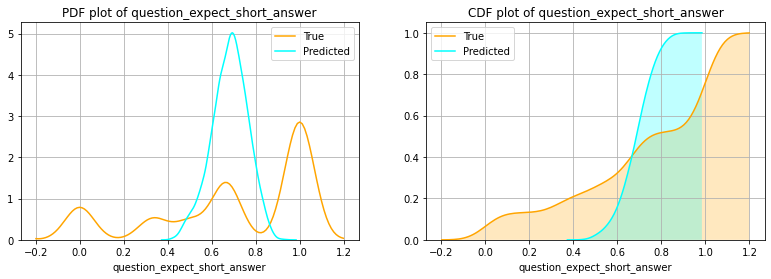

In [31]:
# plot of question_expect_short_answer
class_dist(y_train,train_pred,'question_expect_short_answer')

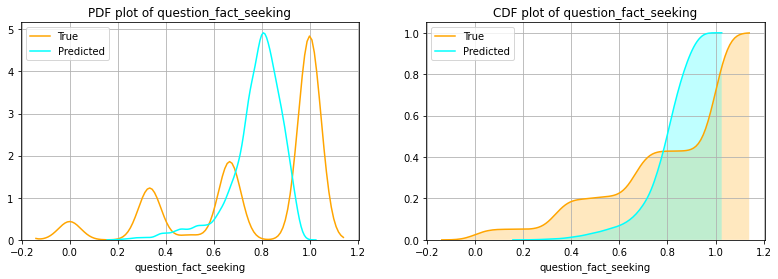

In [32]:
# plot of question_fact_seeking
class_dist(y_train,train_pred,'question_fact_seeking')

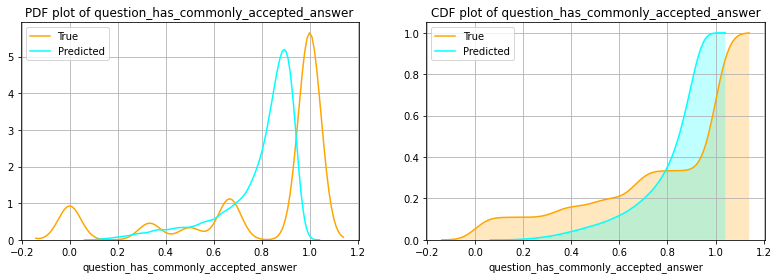

In [33]:
# plot of question_has_commonly_accepted_answer
class_dist(y_train,train_pred,'question_has_commonly_accepted_answer')

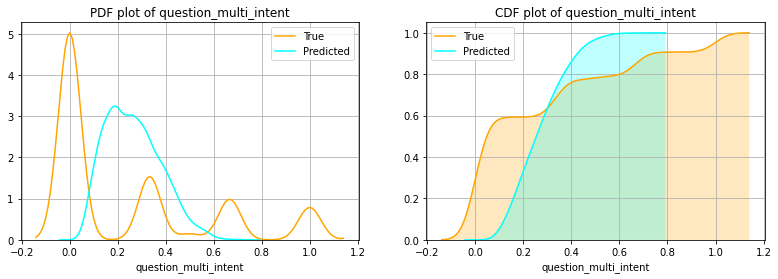

In [34]:
# plot of question_multi_intent 
class_dist(y_train,train_pred,'question_multi_intent')

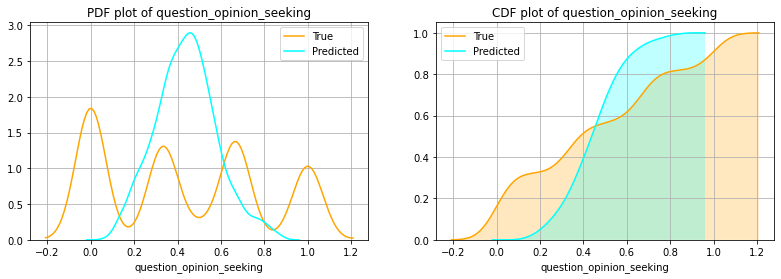

In [35]:
# plot of question_opinion_seeking
class_dist(y_train,train_pred,'question_opinion_seeking')

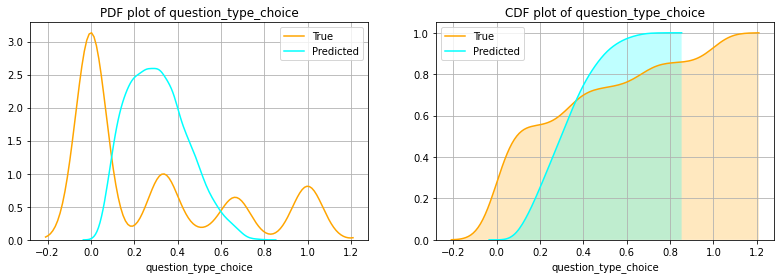

In [36]:
# plot of question_type_choice
class_dist(y_train,train_pred,'question_type_choice')

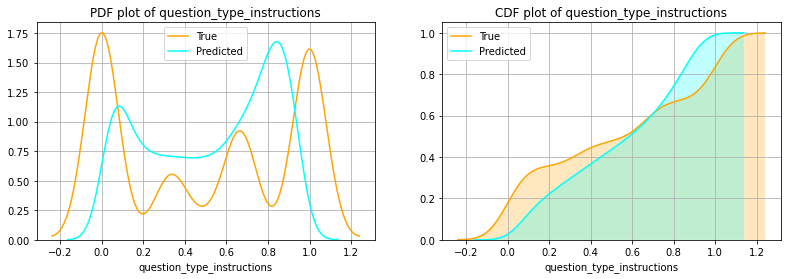

In [38]:
# plot of question_type_instructions 
class_dist(y_train,train_pred,'question_type_instructions')

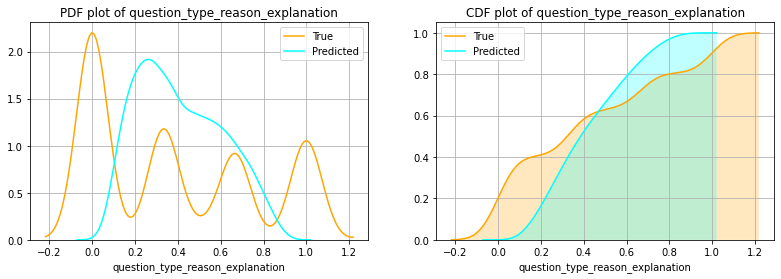

In [40]:
# plot of question_type_reason_explanation
class_dist(y_train,train_pred,'question_type_reason_explanation')

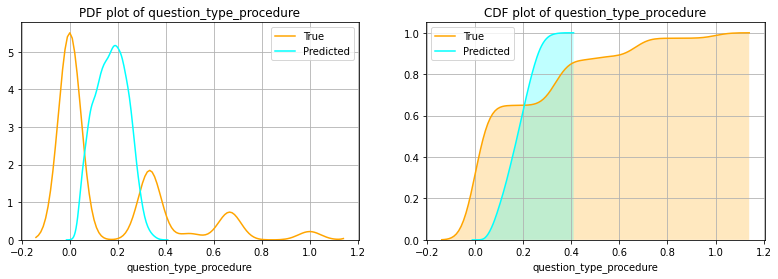

In [41]:
# plot of question_type_procedure
class_dist(y_train,train_pred,'question_type_procedure')

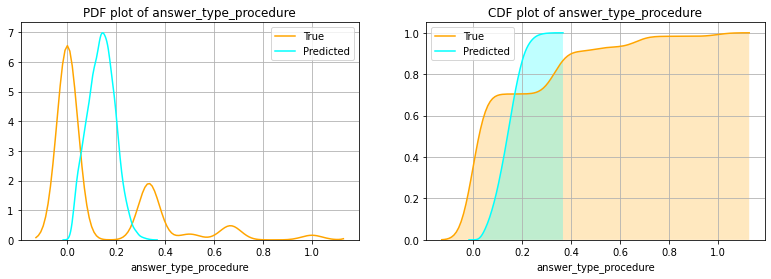

In [42]:
# plot of answer_type_procedure
class_dist(y_train,train_pred,'answer_type_procedure')

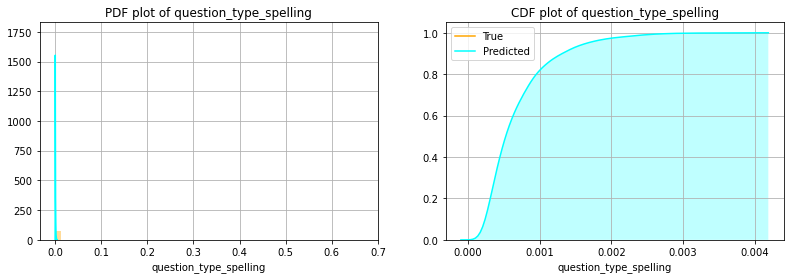

In [82]:
# plot of question_type_spelling
class_dist(y_train,train_pred,'question_type_spelling',hist=True)

##### We can see that values of true and predictions are extremely overlapping for question_type_spelling.

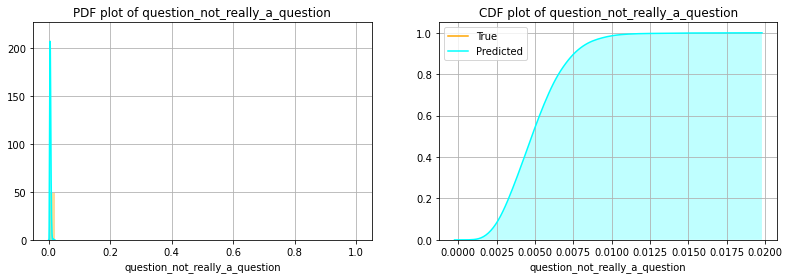

In [81]:
# plot of question_not_really_a_question
class_dist(y_train,train_pred,'question_not_really_a_question',hist=True)

##### We can see that values of true and predictions are extremely overlapping for question_not_really_a_question

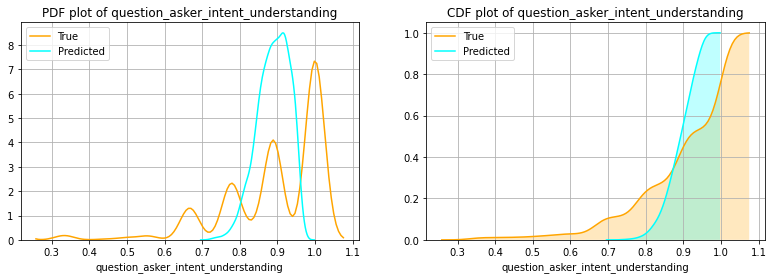

In [55]:
# plot of question_asker_intent_understanding
class_dist(y_train,train_pred,'question_asker_intent_understanding')

#####  Most of the predicted values for `question_asker_intent_understanding`  is around 0.9 and in range 0.8 to 1, but the most occured actual value is 1. 

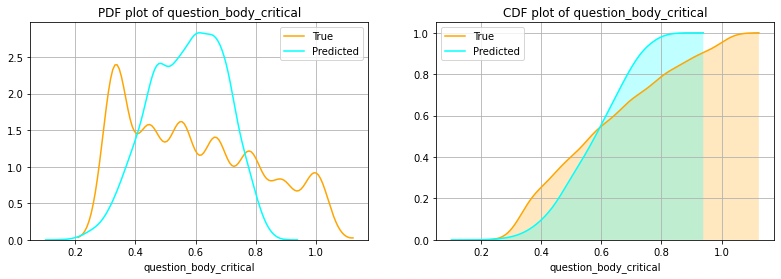

In [56]:
# plot of question_body_critical
class_dist(y_train,train_pred,'question_body_critical')

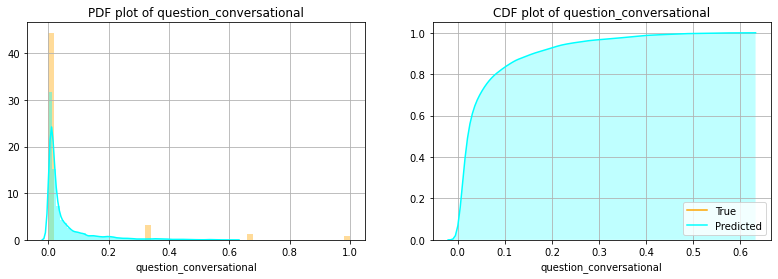

In [57]:
# plot of question_conversational
class_dist(y_train,train_pred,'question_conversational',hist=True)

#### Observation:
From all the distribution plots above, we can say that the prediction values for almost all class-labels are distributed in narrow range of values while actual/true values have wide range of values. 
e.g. `question_asker_intent_understanding` has true values in range between 0.3 to 1, while all predictions are in range of 0.8 to 1, that resulted in increase of error.

In [79]:
# joining train and validation data for furthur analysis 
x = pd.concat([x_train,x_cv])
y = pd.concat([y_train,y_cv])
print(x.shape,y.shape)


(6079, 20) (6079, 30)


In [93]:
# joining train and cv predictions dataframe for furthur analysis
train_pred.index = y_train.index
cv_pred.index = y_cv.index
pred = pd.concat([train_pred,cv_pred])
pred.shape

(6079, 30)

In [53]:
#train_pred = y_train.reset_index(inplace=True)
#train_pred.index = y_train.index

In [98]:
# getting index of datapoints having error equal/greater to/than Mean absolute error
def get_index(column_name):
    indx = []
    for i in x.index:
        if np.absolute(y[column_name][i] - pred[column_name][i])>=mae_dict[column_name]:
            indx.append(i)
    return indx

In [150]:
# getting datapoints where 'question_expect_short_answer' predicted values >= MAE

df_1 = x[x.index.isin(get_index('question_expect_short_answer'))]
df_1.shape

(2912, 20)

##### There are 2912 i.e. 48% datapoints where `question_expect_short_answer` has error atleast equal to its MAE.

In [151]:
# checking  category of question/answers where "question_expect_short_answer" has error >= MAE
(x[x.index.isin(get_index('question_expect_short_answer'))]['category'].value_counts()/(x['category'].value_counts()))*100

culture          48.909657
life_arts        51.622003
science          49.509116
stackoverflow    49.162011
technology       45.309299
Name: category, dtype: float64

##### All categories have high amount of error i.e. around 49% datapoints have errors >=MAE in case of `question_expect_short_answer`

In [152]:
# getting datapoints where 'question_fact_seeking' predicted values >= MAE

df_2 = x[x.index.isin(get_index('question_fact_seeking'))]
df_2.shape

(2270, 20)

##### There are 2270  i.e. around 37% datapoints having error greater than or equal to its MAE for class-label `question_fact_seeking`

In [153]:
# checking  category of question/answers where "question_fact_seeking" has error >= MAE
(x[x.index.isin(get_index('question_fact_seeking'))]['category'].value_counts()/(x['category'].value_counts()))*100

culture          38.110073
life_arts        48.519041
science          18.934081
stackoverflow    43.176377
technology       36.173699
Name: category, dtype: float64

##### Except categroy `science`, all other categories have high amount of error that are greater than MAE for class-label `question_fact_seeking`

In [154]:
# getting datapoints where 'question_has_commonly_accepted_answer' predicted values >= MAE

df_3 = x[x.index.isin(get_index('question_has_commonly_accepted_answer'))]
df_3.shape


(1993, 20)

##### There are 1993  i.e. 32.7% datapoints having error greater than or equal to its MAE for class-label `question_has_commonly_accepted_answer`

In [155]:
# checking  category of question/answers where "question_has_commonly_accepted_answer" has error >= MAE
(x[x.index.isin(get_index('question_has_commonly_accepted_answer'))]['category'].value_counts()/(x['category'].value_counts()))*100

culture          52.440291
life_arts        52.468265
science          27.208976
stackoverflow    19.553073
technology       27.734535
Name: category, dtype: float64

Category `culture`and `life_arts` have most proportions of datapoints (52.4% and 52.4%) datapoints that have error >= MAE for `question_has_commonly_accepted_answer`.
Category `stackoverflow` have least number of datapoints having error >= MAE.


In [156]:
# getting datapoints where 'question_multi_intent' predicted values >= MAE

df_4 = x[x.index.isin(get_index('question_multi_intent'))]
df_4.shape

(2447, 20)

##### There are 2447  i.e. 40% datapoints having error greater than or equal to its MAE for class-label `question_multi_intent`

In [157]:
# checking  category of question/answers where "question_multi_intent" has error >= MAE
(x[x.index.isin(get_index('question_multi_intent'))]['category'].value_counts()/(x['category'].value_counts()))*100

culture          54.205607
life_arts        54.724965
science          50.350631
stackoverflow    20.271349
technology       37.853339
Name: category, dtype: float64

Out of total datapoints, categories `culture`and `life_arts` have 54.2% and 54.7% datapoints that have error >= MAE for `question_multi_intent`.

In [158]:
# getting datapoints where 'question_opinion_seeking' predicted values >= MAE

df_5 = x[x.index.isin(get_index('question_opinion_seeking'))]
df_5.shape

(2795, 20)

##### 2795 which is 46% of datapoints having error greater than or equal to  MAE for `question_opinion_seeking`

In [159]:
# checking  category of question/answers where "question_opinion_seeking" has error >= MAE
(x[x.index.isin(get_index('question_opinion_seeking'))]['category'].value_counts()/(x['category'].value_counts()))*100

culture          48.182762
life_arts        48.942172
science          33.099579
stackoverflow    45.730247
technology       48.136010
Name: category, dtype: float64

Categories `culture, life_arts, technology` have most datapoints (48% for each category) that have error >= MAE for `question_opinion_seeking`

In [164]:
# getting datapoints where 'question_type_reason_explanation' predicted values >= MAE

df_6 = x[x.index.isin(get_index('question_type_reason_explanation'))]
df_6.shape

(2678, 20)

##### 44% datapoints have error >= MAE for question_type_reason_explanation

In [165]:
# checking  category of question/answers where "question_type_reason_explanation" has error >= MAE
(x[x.index.isin(get_index('question_type_reason_explanation'))]['category'].value_counts()/(x['category'].value_counts()))*100

culture          53.686397
life_arts        44.992948
science          40.673212
stackoverflow    41.500399
technology       42.277755
Name: category, dtype: float64

Again category `culture` have highest proportion (53% of its total datapoints) that have error greater than or equal to Mean absolute error for class-label `question_type_reason_explanation`

In [166]:
# getting datapoints where 'answer_type_procedure' predicted values >= MAE

df_7 = x[x.index.isin(get_index('answer_type_procedure'))]
df_7.shape

(2059, 20)

#####  33% of datapoints have error >= MAE for clas-label `answer_type_procedure`

In [167]:
# checking  category of question/answers where "answer_type_procedure" has error >= MAE
(x[x.index.isin(get_index('answer_type_procedure'))]['category'].value_counts()/(x['category'].value_counts()))*100

culture          20.456906
life_arts        29.760226
science          29.593268
stackoverflow    40.861931
technology       38.017206
Name: category, dtype: float64

##### In case of class-label `answer_type_procedure`, categories `stackoverflow` and `technology` have 40% and 38% datapoints with error >= MAE

In [168]:
# getting datapoints where 'answer_type_reason_explanation' predicted values >= MAE

df_8 = x[x.index.isin(get_index('answer_type_reason_explanation'))]
df_8.shape

(2537, 20)

##### 41.7% datapoints have error >= MAE for class-label `answer_type_reason_explanation`

In [169]:
# checking  category of question/answers where "answer_type_reason_explanation" has error >= MAE
(x[x.index.isin(get_index('answer_type_reason_explanation'))]['category'].value_counts()/(x['category'].value_counts()))*100

culture          44.548287
life_arts        41.748942
science          33.520337
stackoverflow    41.739824
technology       43.015158
Name: category, dtype: float64

In case of class-label `answer_type_reason_explanation`, all categories have high number of datapoints with error>=MAE, but category `culture` and `technology` have highest, while category `science` have least amount of datapoints with error>=MAE

#### Observation:
From the above analysis of error based on categories, it seems that all categories have errors greater than MAE for some of the class-labels, but the category having most proportion of datapoints (proportion calculated out of total datapoints present for that particular category) with error greater than or equal to Mean absolute error for most class-labels is `culture`